In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
import sklearn
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# Load the dataset
data = pd.read_csv('Data/test.csv')

In [3]:
# Select relevant features and target variable
features = ['Neighborhood', 'LotArea', 'YearBuilt', 'TotRmsAbvGrd']
target = 'SalePrice'
X = data[features]
y = data[target]

# Rename 'TotRmsAbvGrd' to 'TotalRooms'
X.rename(columns={'TotRmsAbvGrd': 'TotalRooms'}, inplace=True)

In [4]:
# Define categorical and numerical features
categorical_features = ['Neighborhood']
numerical_features = ['LotArea', 'YearBuilt', 'TotalRooms']

In [5]:
# Define preprocessing for numerical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [6]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Define hyperparameters for GridSearchCV
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_features': ['auto', 'sqrt', 'log2'],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}


In [9]:
# Perform GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['LotArea',
                                                                          'YearBuilt',
                                                                          'TotalRooms']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Neighborhood'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None, 10, 20, 30],
                         'regressor__max_features': ['auto', 'sqrt', 'log2'],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5, 10],
                         'regressor__n_estimators': [100, 200]},
             verbose=2)

In [10]:
# Best model from GridSearchCV
best_model = grid_search.best_estimator_

In [11]:
# Validation metrics
y_val_pred = best_model.predict(X_test)
mse_val = mean_squared_error(y_test, y_val_pred)
rmse_val = mean_squared_error(y_test, y_val_pred, squared=False)
r2_val = r2_score(y_test, y_val_pred)

print(f"Validation Mean Squared Error: {mse_val}")
print(f"Validation Root Mean Squared Error: {rmse_val}")
print(f"Validation R^2 Score: {r2_val}")


Validation Mean Squared Error: 71515140.3233588
Validation Root Mean Squared Error: 8456.662481343263
Validation R^2 Score: 0.7040601890495113


In [12]:
# Feature importance visualization
importances = best_model.named_steps['regressor'].feature_importances_
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

In [13]:
# Create a DataFrame to show feature names and their importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances * 100  # Convert to percentage
}).sort_values(by='Importance', ascending=False)


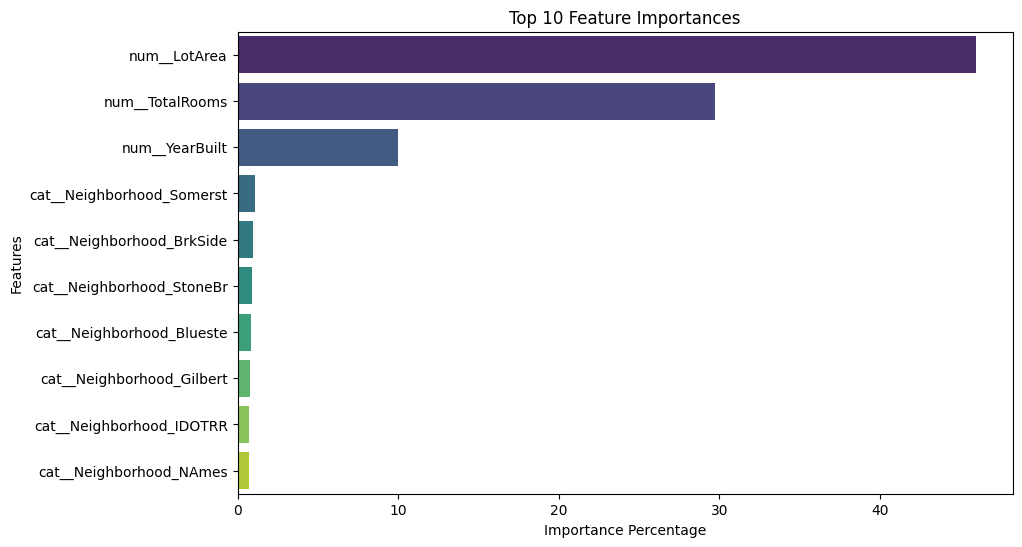

In [14]:
# Plot top 10 feature importances
top_10_features = importance_df.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_features['Importance'], y=top_10_features['Feature'], palette='viridis')
plt.xlabel('Importance Percentage')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances')
plt.show()


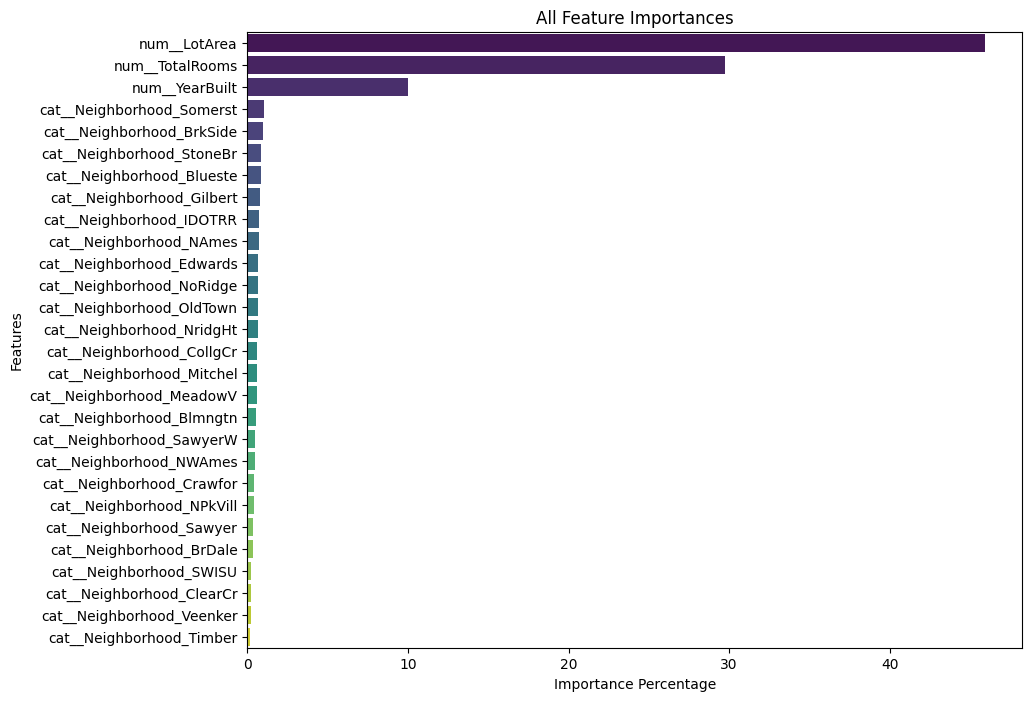

In [15]:
# Plot all feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], palette='viridis')
plt.xlabel('Importance Percentage')
plt.ylabel('Features')
plt.title('All Feature Importances')
plt.show()

In [16]:
# Save the model using the specified method
with open('house_price_model.pkl', 'wb') as model_file:
    joblib.dump(best_model, model_file)
